## Acknowledgement
---

Dataset ini diambil dari [kaggle.com](https://www.kaggle.com/datasets/rajgupta2019/medical-insurance-dataset)

# Import libraries
---


In [1]:
# data manipulation
import pandas as pd
import numpy as np

# data visualisation
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
sns.set_style('whitegrid')

# data preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder

# modeling
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

# metrics
from sklearn.metrics import mean_squared_error

# Data loading
---

In [2]:
df = pd.read_csv('Train_Data.csv')
df.head()

,age,sex,bmi,smoker,region,children,charges
0,21.000000,male,25.745000,no,northeast,2,3279.868550
1,36.976978,female,25.744165,yes,southeast,3,21454.494239
2,18.000000,male,30.030000,no,southeast,1,1720.353700
3,37.000000,male,30.676891,no,northeast,3,6801.437542
4,58.000000,male,32.010000,no,southeast,1,11946.625900


In [3]:
print('Dataframe memiliki total {} data dan {} kolom'.format(df.shape[0], df.shape[1]))

Dataframe memiliki total 3630 data dan 7 kolom


Mengecek apakah dataframe mempunya missing value

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3630 entries, 0 to 3629
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       3630 non-null   float64
 1   sex       3630 non-null   object 
 2   bmi       3630 non-null   float64
 3   smoker    3630 non-null   object 
 4   region    3630 non-null   object 
 5   children  3630 non-null   int64  
 6   charges   3630 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 198.6+ KB


In [5]:
print('Dataframe memiliki total {} missing value'.format(df.isnull().sum().sum()))

Dataframe memiliki total 0 missing value


# Exploratory data analysis
---
Sebelum masuk ke data preprocessing dan modeling, kita harus mengeksplor data agar kita dapat menemukan gambaran tentang data dan mendapat insight dari data yang dapat digunakan pada proses data preprocessing.

Dataframe mempunya 7 kolom dengan deskripsi sebagai berikut:
* age : merupakan umur dari responden
* sex : merupakan jenis kelamin dari responden
* bmi : merupakan bmi dari responden (berat badan (kg) / tinggi badan<sup>2</sup> (m))
* smoker : merupakan keterangan perokok atau tidak dari responden
* region : merupakan negara responden tinggal
* children : merupakan berapa banyak anak yang dimiliki responden
* charges : merupakan biaya yang harus dibayar oleh responden

In [6]:
df.describe()

,age,bmi,children,charges
count,3630.000000,3630.000000,3630.000000,3630.000000
mean,38.887036,30.629652,2.503581,12784.808644
std,12.151029,5.441307,1.712568,10746.166743
min,18.000000,15.960000,0.000000,1121.873900
25%,29.000000,26.694526,1.000000,5654.818262
50%,39.170922,30.200000,3.000000,9443.807222
75%,48.343281,34.100000,4.000000,14680.407505
max,64.000000,53.130000,5.000000,63770.428010


## Data visualisation

<AxesSubplot:>

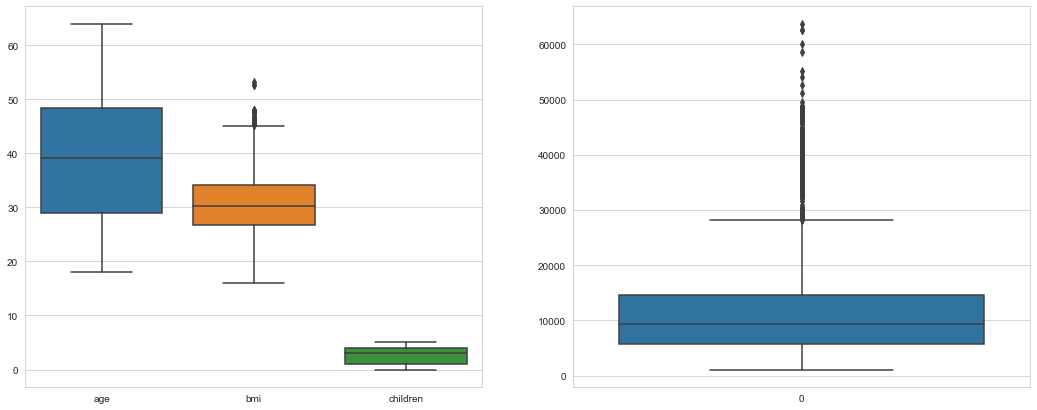

In [7]:
numerical_col = [col for col in df.columns if df[col].dtype != object]
fig, ax = plt.subplots(1, 2, figsize=(18,7))
sns.boxplot(data=df[numerical_col[:3]], ax=ax[0])
sns.boxplot(data=df[numerical_col[-1]])

Dapat kita lihat dari visualisasi data di atas terdapat outlier pada fitur bmi dan charges. Biasanya kita dapat menggunakan IQR Method untuk menangani outlier, namun pada dataset kali ini kita tidak akan melakukannya.

### Univariate analysis
Untuk melakukan univariate analysis, kita akan membuat dataframe sementara agar dapat melakukan preprocessing pada data tanpa mengubah dataframe utama

In [8]:
temp_df = df
temp_df.head()

,age,sex,bmi,smoker,region,children,charges
0,21.000000,male,25.745000,no,northeast,2,3279.868550
1,36.976978,female,25.744165,yes,southeast,3,21454.494239
2,18.000000,male,30.030000,no,southeast,1,1720.353700
3,37.000000,male,30.676891,no,northeast,3,6801.437542
4,58.000000,male,32.010000,no,southeast,1,11946.625900


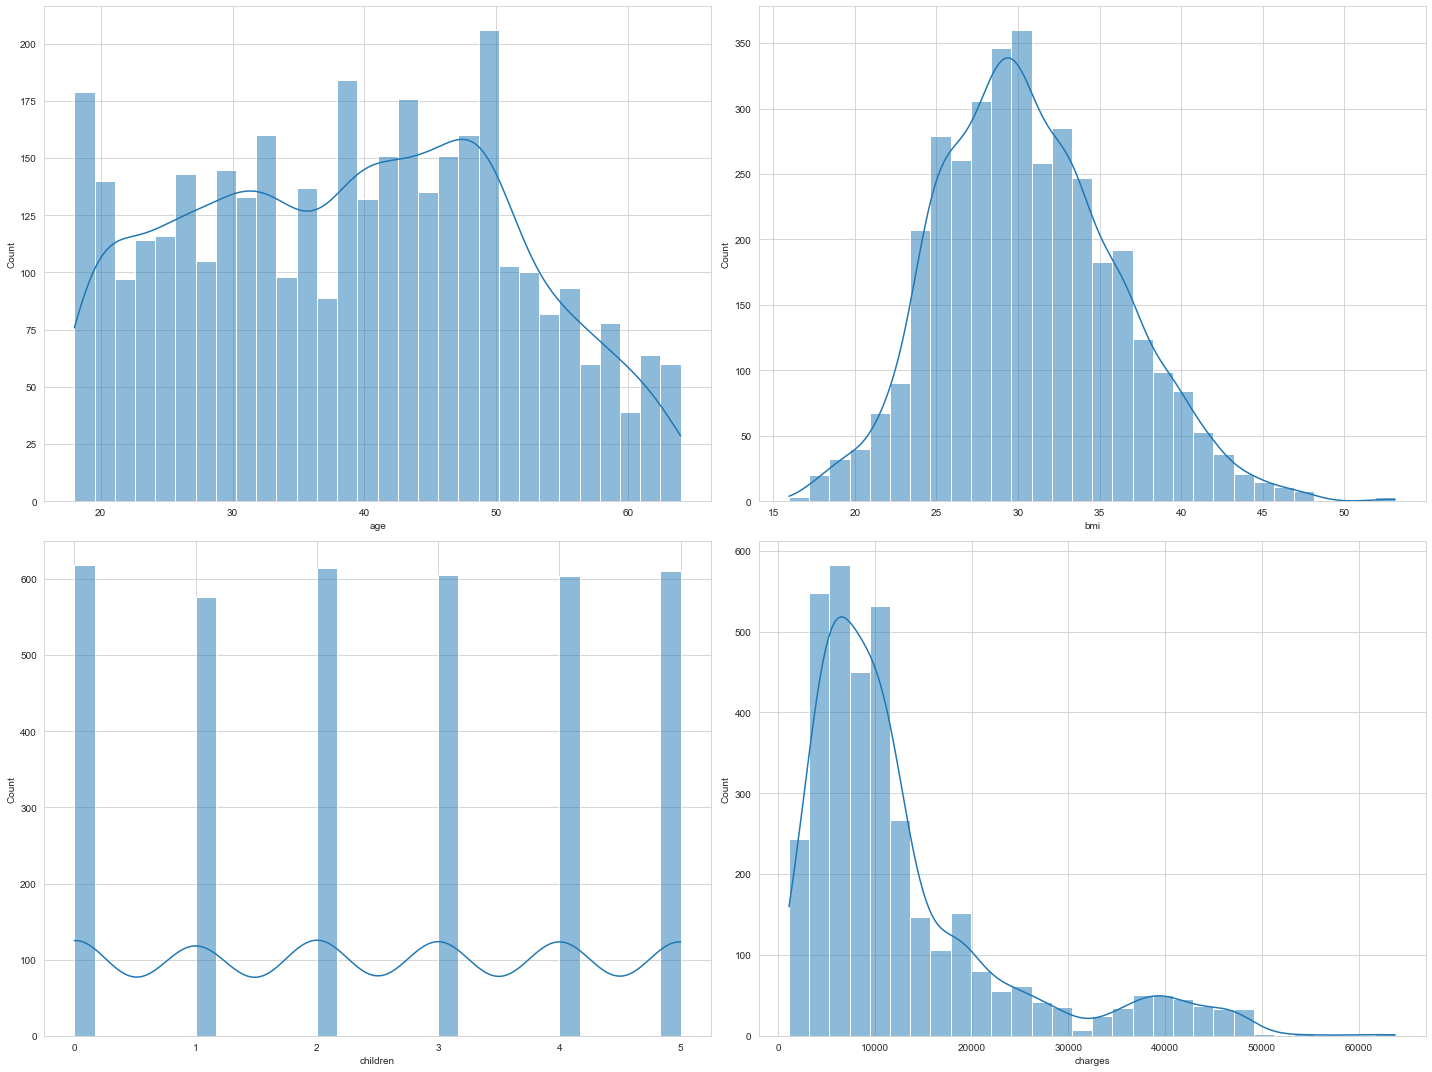

In [9]:
rows = 2
cols = 2
fig = plt.figure(figsize=(20,15))
for i, col in enumerate(numerical_col):
  ax = fig.add_subplot(rows, cols, i + 1)
  sns.histplot(x=temp_df[col], bins=30, kde=True, ax=ax)
fig.tight_layout()
plt.show()

Dari visualisasi di bawah ini dapat disimpulkan bahwa semakin bertambahnya umur tidak terlalu mempengaruhi pada harga asuransi

<AxesSubplot:title={'center':'Correlation between charges vs age'}, xlabel='age', ylabel='charges'>

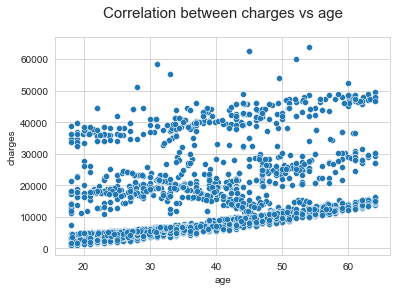

In [10]:
plt.title('Correlation between charges vs age', fontsize=15, pad=20)
sns.scatterplot(x='age', y='charges', data=temp_df)

Dari visualisasi di bawah ini kita mendapatkan insight yang menarik. Karena orang dengan bmi tinggi belum tentu memiliki harga isuransi yang tinggi

<AxesSubplot:title={'center':'Correlation between charges vs bmi'}, xlabel='bmi', ylabel='charges'>

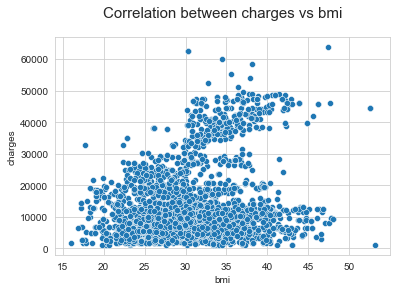

In [11]:
plt.title('Correlation between charges vs bmi', fontsize=15, pad=20)
sns.scatterplot(x='bmi', y='charges', data=temp_df)

Dari visualisasi di bawah ini dapat kita lihat bahwa orang yang belum memiliki anak cenderung mempunya harga asuransi yang lebih tinggi

<AxesSubplot:title={'center':'Correlation between charges vs children'}, xlabel='children', ylabel='charges'>

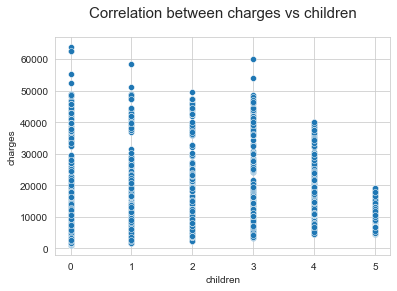

In [12]:
plt.title('Correlation between charges vs children', fontsize=15, pad=20)
sns.scatterplot(x='children', y='charges', data=temp_df)

Setelah melihat korelasi antara numerical features, selanjutnya kita akan mengeksplor persebaran data pada categorical features

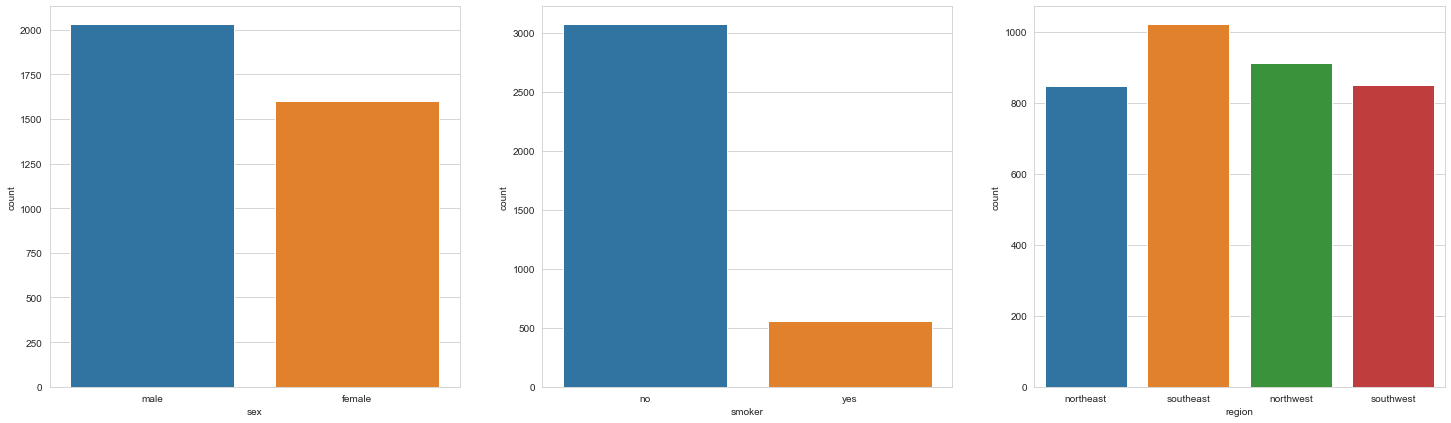

In [13]:
categorical_col = [col for col in df.columns if df[col].dtype == object]
fig, ax = plt.subplots(1, len(categorical_col), figsize=(25,7))
for i, col in enumerate(categorical_col):
    sns.countplot(data=temp_df, x=col, ax=ax[i])

Setelah melihat persebaran data secara universal sekarang kita akan melihat persebaran data berdasarkan region

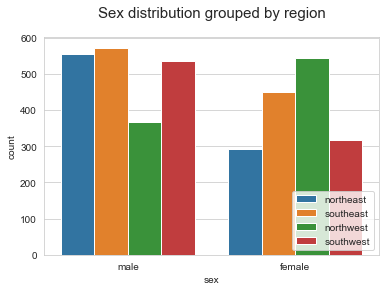

In [14]:
plt.title('Sex distribution grouped by region', fontsize=15, pad=20)
sns.countplot(data=temp_df, x='sex', hue='region')
plt.legend(loc='lower right')

Dari persebaran data jenis kelamin di atas, dapat kita lihat bahwa kebanyakan laki laki berasal dari daerah southeast dan kebanyakan perempuan berasal dari northwest

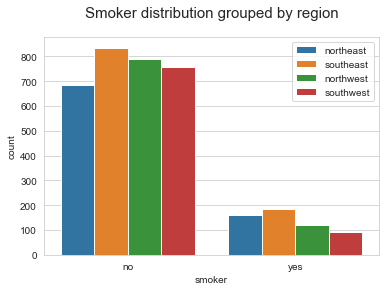

In [15]:
plt.title('Smoker distribution grouped by region', fontsize=15, pad=20)
sns.countplot(data=temp_df, x='smoker', hue='region')
plt.legend(loc='upper right')

Dari persebaran data perokok di atas, dapat kita lihat bahwa jumlah orang yang perokok pada tiap daerah memiliki rasio yang lebih sedikit dari pada yang tidak merokok

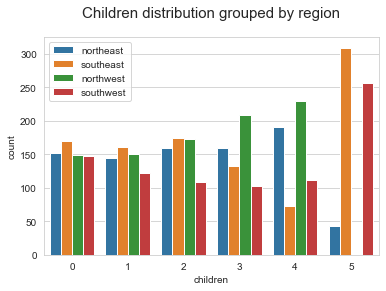

In [16]:
plt.title('Children distribution grouped by region', fontsize=15, pad=20)
sns.countplot(data=temp_df, x='children', hue='region')
plt.legend(loc='upper left')

Dari persebaran data anak di atas, dapat kita lihat bahwa daerah yang memiliki jumlah anak terbanyak terdapat pada daerah southeast. Selanjutnya kita akan melihat persebaran data perokok berdasarkan jenis kelamin

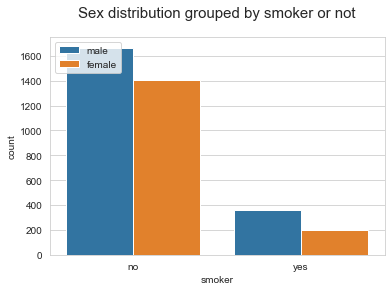

In [17]:
plt.title('Sex distribution grouped by smoker or not', fontsize=15, pad=20)
sns.countplot(data=temp_df, x='smoker', hue='sex')
plt.legend(loc='upper left')

Selanjutnya kita akan melihat total anak anak pada setiap daerah

<AxesSubplot:title={'center':'Total children distribution grouped by region'}, xlabel='region', ylabel='children'>

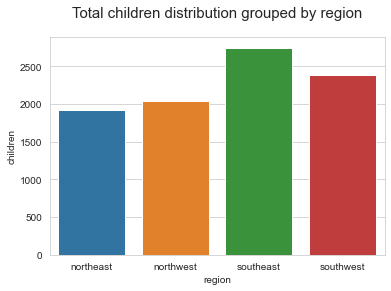

In [18]:
children = temp_df.groupby('region')[['children']].sum()
plt.title('Total children distribution grouped by region', fontsize=15, pad=20)
sns.barplot(data=children, x=children.index, y='children')

### Multivariate analysis

Selanjutnya kita akan melihat korelasi antar fitur

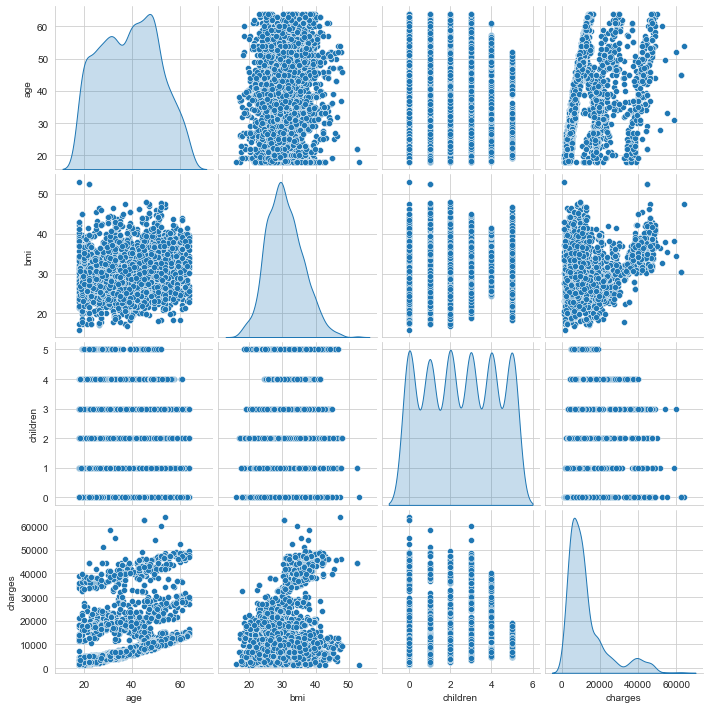

In [19]:
sns.pairplot(df[numerical_col], diag_kind='kde')

Untuk lebih jelasnya kita dapat menggunakan heatmap agar dapat melihat antar fitur memiliki korelasi kuat atau lemah

<AxesSubplot:title={'center':'Correlation matrix for numerical features'}>

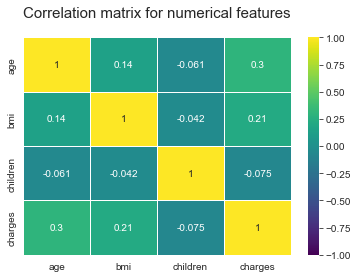

In [20]:
plt.title('Correlation matrix for numerical features', fontsize=15, pad=20)
sns.heatmap(df[numerical_col].corr(), annot=True, vmin=-1, vmax=1, cmap='viridis', linewidth=1)

# Data Preparation
---

Karena terdapat categorical features pada data, maka pertama kita akan melakukan encoding pada categorical features. Kita dapat melakukan encoding dengan menggunakan OrdinalEncoder dari sklearn

In [21]:
df.head()

,age,sex,bmi,smoker,region,children,charges
0,21.000000,male,25.745000,no,northeast,2,3279.868550
1,36.976978,female,25.744165,yes,southeast,3,21454.494239
2,18.000000,male,30.030000,no,southeast,1,1720.353700
3,37.000000,male,30.676891,no,northeast,3,6801.437542
4,58.000000,male,32.010000,no,southeast,1,11946.625900


In [22]:
encoder = OrdinalEncoder()
encoded_df = df
encoded_df[categorical_col] = pd.DataFrame(encoder.fit_transform(df[categorical_col]))
encoded_df.head()

,age,sex,bmi,smoker,region,children,charges
0,21.000000,1.0,25.745000,0.0,0.0,2,3279.868550
1,36.976978,0.0,25.744165,1.0,2.0,3,21454.494239
2,18.000000,1.0,30.030000,0.0,2.0,1,1720.353700
3,37.000000,1.0,30.676891,0.0,0.0,3,6801.437542
4,58.000000,1.0,32.010000,0.0,2.0,1,11946.625900


Setelah melakukan encoding pada categorical features, selanjutnya kita akan membulatkan features age. Karena tidak mungkin kan umur desimal

In [23]:
encoded_df['age'] = encoded_df['age'].apply(np.ceil).astype(np.int64)
encoded_df['bmi'] = encoded_df['bmi'].apply(lambda x: np.round(x, 2))
encoded_df.head()

,age,sex,bmi,smoker,region,children,charges
0,21,1.0,25.74,0.0,0.0,2,3279.868550
1,37,0.0,25.74,1.0,2.0,3,21454.494239
2,18,1.0,30.03,0.0,2.0,1,1720.353700
3,37,1.0,30.68,0.0,0.0,3,6801.437542
4,58,1.0,32.01,0.0,2.0,1,11946.625900


Setelah melakukan semua data preprocessing selanjutnya kita akan menentukan dependan dan independen variabel

In [24]:
X = encoded_df.iloc[:, :-1].values
y = encoded_df.iloc[:, -1].values

Setelah menentukan variabel independen dan dependen, selanjutnya kita akan melakukan splitting dataset ke dalam train set dan test set

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=123)

In [26]:
print('Total X_train:', len(X_train), 'records')
print('Total y_train:', len(y_train), 'records')
print('Total X_test:', len(X_test), 'records')
print('Total y_test:', len(y_test), 'records')

Total X_train: 2904 records
Total y_train: 2904 records
Total X_test: 726 records
Total y_test: 726 records


In [27]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (2904, 6)
y_train shape: (2904,)
X_test shape: (726, 6)
y_test shape: (726,)


In [28]:
models = pd.DataFrame(columns=['train_mse', 'test_mse'], index=['SVR', 'LinearRegression', 'GradientBoost'])

# Modeling
---

### Hyperparameter tuning
Hyperparameter tuning adalah salah satu teknik yang dilakukan akan model dapat berjalan dengan performa terbaik. Biasanya dalam hyperparameter tuning, hyperparameter akan ditentukan secara acak oleh teknisi. Namun jika tidak ingin mencoba coba hyperparameter mana yang terbaik, kita dapat menggunakan GridSearch. GridSearch merupakan sebuah teknik yang memungkinkan kita untuk menguji beberapa hyperparameter sekaligus pada sebuah model

In [29]:
def grid_search(model, hyperparameter):
    result = GridSearchCV(
        model,
        hyperparameter,
        cv=5,
        verbose=1,
        n_jobs=6
    )
    
    return result

In [30]:
svr = SVR()
hyperparameters = {
    'kernel': ['rbf'],
    'C': [0.001, 0.01, 0.1, 10, 100, 1000],
    'gamma': [0.3, 0.03, 0.003, 0.0003, 'scale', 'auto']
}

svr_search = grid_search(svr, hyperparameters)
svr_search.fit(X_train, y_train)
print(svr_search.best_params_)
print(svr_search.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
{'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}
0.06355003959228633


In [31]:
linear_regression = LinearRegression()
hyperparameters = {}

linear_search = grid_search(linear_regression, hyperparameters)
linear_search.fit(X_train, y_train)
print(linear_search.best_params_)
print(linear_search.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{}
0.7073561939703197


In [32]:
gradient_boost = GradientBoostingRegressor()
hyperparameters = {
    'learning_rate': [1e-1, 1e-2, 1e-3, 1e-4],
    'n_estimators': [250, 500, 750, 1000],
    'criterion': ['friedman_mse', 'squared_error']
}

gradient_boost_search = grid_search(gradient_boost, hyperparameters)
gradient_boost_search.fit(X_train, y_train)
print(gradient_boost_search.best_params_)
print(gradient_boost_search.best_score_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
{'criterion': 'squared_error', 'learning_rate': 0.1, 'n_estimators': 500}
0.868692241685143


### Model Training

Kita akan melakukan training pada semua model untuk melihat model mana yang memiliki mse terendah

In [33]:
svr = SVR(C=1000, gamma='auto', kernel='rbf')
svr.fit(X_train, y_train)

SVR(C=1000, gamma='auto')

In [34]:
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)

LinearRegression()

In [35]:
gradient_boost = GradientBoostingRegressor(criterion='squared_error', learning_rate=1e-1, n_estimators=500)
gradient_boost.fit(X_train, y_train)

GradientBoostingRegressor(criterion='squared_error', n_estimators=500)

### Model Evaluation

In [36]:
model_dict = {
    'SVR': svr,
    'LinearRegression': linear_regression,
    'GradientBoost': gradient_boost
}

for name, model in model_dict.items():
    models.loc[name, 'train_mse'] = mean_squared_error(y_train, model.predict(X_train))
    models.loc[name, 'test_mse'] = mean_squared_error(y_test, model.predict(X_test))

models.head()

,train_mse,test_mse
SVR,98076683.778333,108491577.509645
LinearRegression,33145267.308484,30747334.712031
GradientBoost,7103268.223391,12918033.124348


<AxesSubplot:>

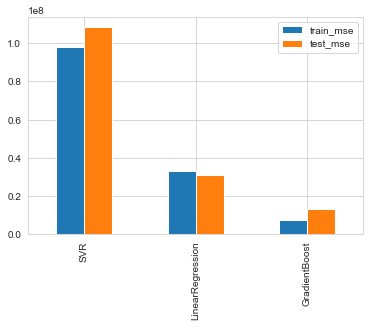

In [37]:
models.sort_values(by='test_mse', ascending=False).plot(kind='bar', zorder=3)